# メモ
- 内野情報の追加
    

# 特徴量
## pitch
- 試合内投球数
- イニング
- イニング内打席数
- 打席内投球数
- 投手投球左右
- 打者打席左右
- 打者打順
- プレイ前アウト数
- プレイ前ボール数
- プレイ前ストライク数
- プレイ前走者状況

### 追加
- ホームチームID
- アウェイチームID
- 球場ID
- 試合種別詳細
- 表裏
- 打者チームID
- 打者守備位置
- 打者試合内打席数
- プレイ前ホームチーム得点数
- プレイ前アウェイチーム得点数
- 投手登板順
- 投手イニング投球数
- 投手試合内対戦打者数

## player
### 打者&投手
- 位置
- 身長
- 体重
- 年俸
- 出身国

### 追加
- ドラフト順位

In [3]:
import pandas as pd
import numpy as np

ver = "v6"
pd.set_option('display.max_columns', 500)
pd.set_option('display.max_rows', 500)

df_tr_pitch = pd.read_csv('../data/train_pitch.csv')
df_tr_player = pd.read_csv('../data/train_player.csv')
df_te_pitch = pd.read_csv('../data/test_pitch.csv')
df_te_player = pd.read_csv('../data/test_player.csv')
df_smp = pd.read_csv('../data/sample_submit_ball_type.csv', header=None)

In [4]:
import sys
sys.path.append("..")

import tqdm
import time
import preprocess
import importlib
import re
importlib.reload(preprocess)
cnvrt = preprocess.Converter()
df_tr = cnvrt.convert_df(df_tr_pitch, df_tr_player)

In [5]:
features = []
remove = ["num_data", "cat_pitcher_role", "cat_training_player_batter", "cat_training_player_pitcher", "cat_position_pitcher"]
for x in df_tr.keys():
    if re.match(r"^num_|^ord_|^cat_", x) is not None and re.match(r"^cat_", x) is None and x not in remove:
        features.append(x)
features

['num_game_throw',
 'ord_inning',
 'num_inning_bat',
 'num_pitch_in_bat',
 'ord_pitching',
 'num_pitcher_vs',
 'num_pitching_game',
 'num_pitching_inning',
 'ord_bat',
 'num_batter_batting',
 'num_point_home',
 'num_point_away',
 'num_out',
 'num_ball',
 'num_strike',
 'num_height_batter',
 'num_weight_batter',
 'ord_draft_batter',
 'num_annual_salary_batter',
 'num_height_pitcher',
 'num_weight_pitcher',
 'ord_draft_pitcher',
 'num_annual_salary_pitcher',
 'num_height_catcher',
 'num_weight_catcher',
 'ord_draft_catcher',
 'num_annual_salary_catcher',
 'num_height_first',
 'num_weight_first',
 'ord_draft_first',
 'num_annual_salary_first',
 'num_height_second',
 'num_weight_second',
 'ord_draft_second',
 'num_annual_salary_second',
 'num_height_third',
 'num_weight_third',
 'ord_draft_third',
 'num_annual_salary_third',
 'num_height_short',
 'num_weight_short',
 'ord_draft_short',
 'num_annual_salary_short']

In [6]:
tr_X = df_tr[features]
tr_Y = df_tr["ball_type"]

In [7]:
from sklearn.model_selection import KFold

cv_num = 5
kf = KFold(n_splits=cv_num, shuffle=True)

kf_index = []
for tr_i, te_i in kf.split(tr_X):
    kf_index.append([tr_i, te_i])

In [8]:
from sklearn.metrics import log_loss # モデル評価用(logloss) 
import lightgbm as lgb #LightGBM

# params
params = {
    "task": "train",
    "boosting_type": "gbdt",
    "objective": "multiclass",
    "num_class": 8,
    "metric": "multi_logloss",
    "verbose": 2
}

# train
loss_list = []
models = []
for i, kf in enumerate(kf_index):
    train_x = tr_X.iloc[kf[0]]
    train_y = tr_Y.iloc[kf[0]]
    test_x = tr_X.iloc[kf[1]]
    test_y = tr_Y.iloc[kf[1]]
    
    
    train_data = lgb.Dataset(train_x, label=train_y)
    eval_data = lgb.Dataset(test_x, label=test_y)
    
    print(f"train {i}")
    gbm = lgb.train(
        params,
        train_data, 
        valid_sets=eval_data,
        num_boost_round=500,
        verbose_eval=50
    )
    
    models.append(gbm)

train 0
[50]	valid_0's multi_logloss: 1.28475
[100]	valid_0's multi_logloss: 1.23457
[150]	valid_0's multi_logloss: 1.21529
[200]	valid_0's multi_logloss: 1.20401
[250]	valid_0's multi_logloss: 1.1962
[300]	valid_0's multi_logloss: 1.18986
[350]	valid_0's multi_logloss: 1.18537
[400]	valid_0's multi_logloss: 1.18226
[450]	valid_0's multi_logloss: 1.17981
[500]	valid_0's multi_logloss: 1.17748
train 1
[50]	valid_0's multi_logloss: 1.28374
[100]	valid_0's multi_logloss: 1.23411
[150]	valid_0's multi_logloss: 1.2145
[200]	valid_0's multi_logloss: 1.2033
[250]	valid_0's multi_logloss: 1.1961
[300]	valid_0's multi_logloss: 1.1901
[350]	valid_0's multi_logloss: 1.18563
[400]	valid_0's multi_logloss: 1.18152
[450]	valid_0's multi_logloss: 1.17899
[500]	valid_0's multi_logloss: 1.1768
train 2
[50]	valid_0's multi_logloss: 1.27893
[100]	valid_0's multi_logloss: 1.22975
[150]	valid_0's multi_logloss: 1.21068
[200]	valid_0's multi_logloss: 1.19958
[250]	valid_0's multi_logloss: 1.19141
[300]	vali

In [9]:
import pickle
with open(f"./models/{ver}.pickle", "wb") as f:
    pickle.dump(models, f)

# 予測

In [10]:
df_te = cnvrt.convert_df(df_te_pitch, df_te_player, isTrain=False)
te_X = df_te[features]

In [11]:
result = []
for i, model in enumerate(models):
    start = time.time()
    print(f"start model{i}")
    result.append(model.predict(te_X))
    print(f"end time : {time.time()-start}")

start model0
end time : 98.98285913467407
start model1
end time : 93.19333982467651
start model2
end time : 91.4049301147461
start model3
end time : 90.2121958732605
start model4
end time : 94.12299013137817


In [12]:
from scipy.special import softmax
result = np.array(result)
final_result = np.sum(result, axis=0)
final_result = softmax(final_result, axis=1)

In [13]:
df_submit = pd.concat([df_smp[0], pd.DataFrame(final_result)], axis=1).reset_index(drop=True)
df_submit.columns = range(df_submit.shape[1])
df_submit.to_csv(f"submits/{ver}.csv", index=False, header=False)

# importance

In [14]:
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

In [15]:
imp = pd.DataFrame(
    {"feature": train_x.keys(),
     "importance": models[0].feature_importance()})
imp

,feature,importance
0,num_game_throw,7566
1,ord_inning,1187
2,num_inning_bat,1936
3,num_pitch_in_bat,3764
4,ord_pitching,925
5,num_pitcher_vs,2147
6,num_pitching_game,6844
7,num_pitching_inning,5476
8,ord_bat,2538
9,num_batter_batting,814


findfont: Font family ['IPAPGothic'] not found. Falling back to DejaVu Sans.
findfont: Font family ['IPAPGothic'] not found. Falling back to DejaVu Sans.


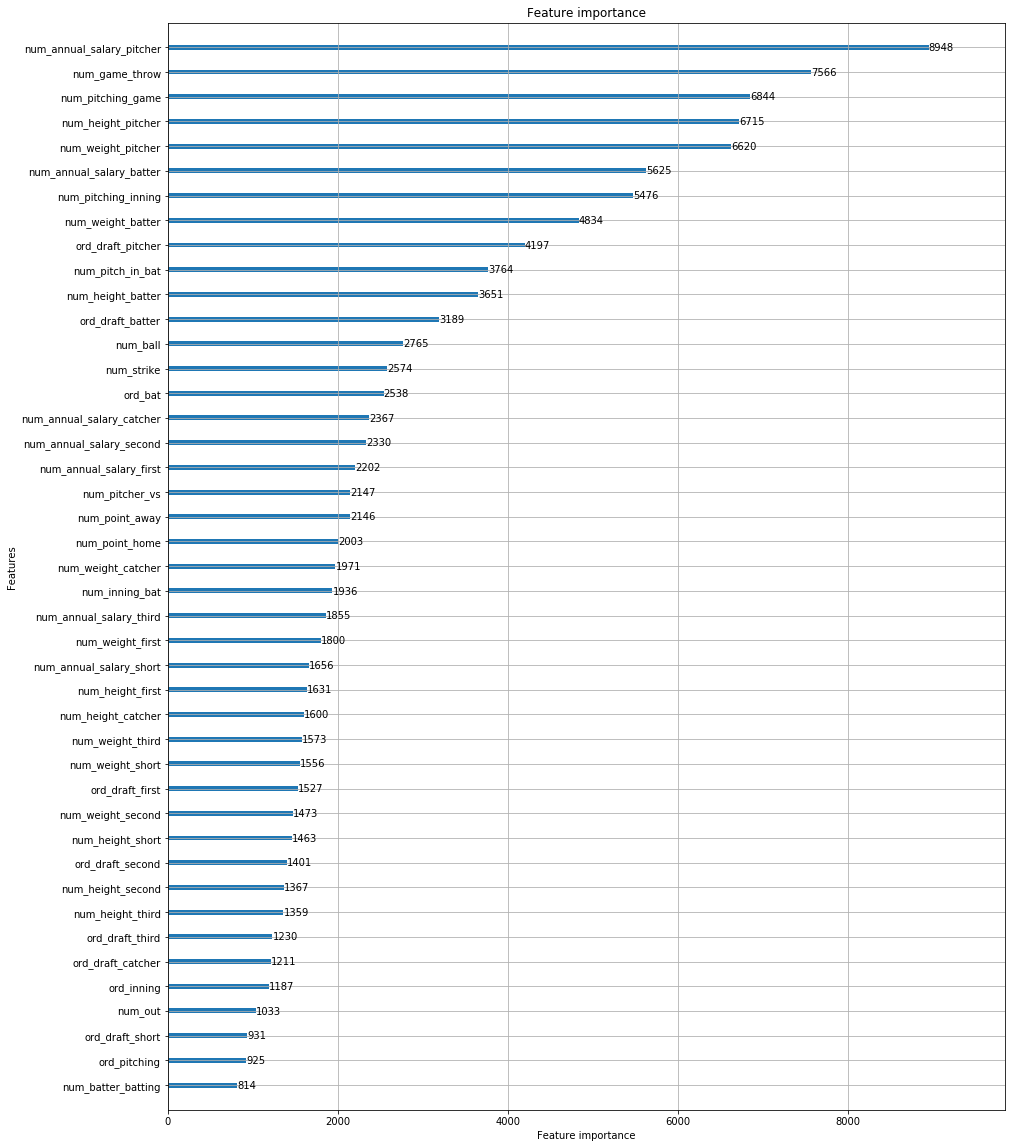

In [16]:
lgb.plot_importance(models[0], figsize=(15,20), ignore_zero=False)